Osnabrück University - A&C: Computational Cognition (Summer Term 2019)

# Exercise Sheet 05: Eye tracking

## Introduction

This week's sheet should be solved and handed in at 14:00 at **Tuesday, May 28, 2019**. If you need help (and Google and other resources were not enough), feel free to contact your tutors. Please push your results to your Github group folder.

For this exercise sheet you will have 2 weeks and the sheet is also worth of 30 points. In this exercise sheet you will start to work with eye tracking data. Note that the data we will use here are not raw gaze data and contain coordinates of fixation points.

The dataset is distributed freely by a following study: [Wilming, N. Dryad](https://www.nature.com/articles/sdata2016126#data-citations). By clicking on the link in the section "Data Citations" you will get redirected to the page where you can download all the data openly distributed. Read below for description of each file.

##### necessary
*etdb_v1.0*: This is the main data file. The hdf5 file consists of all the fixation data and the metadata.  
*Read gaze data with python*: Python script to read hdf5 file as a dataframe.  
*Stimuli/i*: Zip file containing image stimuli used in the study. The encoding convention is same as in the dataframe.
##### optional
*Metadata*: This is the csv file giving overview of all studies.

In [ ]:
%pip install h5py # make sure to install h5py which is used in fixmat.py

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.anova import *
from Data.fixmat import *
from statsmodels.formula.api import ols
sns.set_style("whitegrid")

## Assignment 0: Peer review for sheet 04 [3 pts]

Each group reviews the solutions of two other groups and give points according to the given point distribution considering the correctness of the solution. For this reviews the tutors will give you up to 3 points each week. Follow a distributed comment guidelines if you are unsure.

| * |Group 1|Group 2|Group 3|Group 4|Group 5|Group 6|Group 7|Group 8|Group 9|Group 10|Group 11|
| ------- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ------ | ------ |
| check solutions of group: | 5, 9 | 1, 6  | 4, 7  | 7, 2 | 2, 11 | 8, 3 | 3, 10  | 11, 1  | 10, 4  | 6, 8  | 9, 5   |


## Assignment 1: Checking the data distribution [9 pts]

### a) loading datasets [0 pts]
As with any other datasets, the first step is to get an idea of the dataset. Check the meta data and column of the dataframe.

In [2]:
# use a fixmat.py to load the hdf5 format data as a panda dataframe
DATAPATH = "Data/"
df, meta = load(DATAPATH+'etdb_v1.0.hdf5', "Baseline")

In [64]:
meta

{'# Fix.': 203772,
 '# Obs.': 48,
 'Age': '23.1 (19-28)',
 'Article': 15.0,
 'Categories': '7,8,10,11',
 'Disp. Size (degree)': '29x22',
 'Display': 'SM1100',
 'Display resolution (pixels)': '1280x960',
 'Eye Tracker': 'EL II',
 'ID': 3,
 'Img. Pos. (pixel)': '0,0',
 'Img. size (pixel)': '1280x960',
 'PPD': 45.6,
 'Sampling freq. (Hz)': '500 Hz',
 'Task': 'FV',
 'V. Dur.': '6s',
 'V. dist. (cm) ': 80,
 'Val. error (degrees)': 0.3}

In [4]:
df.columns

Index(['SUBJECTINDEX', 'category', 'dataset_nr', 'end', 'eye', 'filenumber',
       'fix', 'pupil', 'start', 'trial', 'x', 'y'],
      dtype='object')

### b) data cleaning [3 pts]
We want to clean the dataframe so that it is handy for us to work with it.
- How many fixations do we have per category? ```agg``` function might be helpful.
- categories are encoded using a number. Add a column to the dataframe that has approporiate string value for that category (e.g. code 11.0 to "Pink-noise"). The category names can be found on Figure 2 of the paper.
- since measurements lasted for 6 seconds, any fixation points that have a onset time before 0 sec and end time more than 6 sec are erroneous. Remove these rows.
- also remove all rows with any NaN values.
- add a column called ```duration``` and compute the duration of each fixation.
- It is known from previous literature that fixations typically last between 100 msec to 400 msec. Remove all rows with unrealistic  fixation duration.
- check how many data points got removed for each category. Let's hope that we didn't delete too many rows from a single category.
- count the number of fixations for each trial. To do this, you can use the aggregate method to count the number of rows for each category.
- print the mean duration and the mean number of fixation across all trials. Are they in a realistic range?

In [3]:
import warnings
# ignore warnings about writing on copy of slice of data frame
warnings.filterwarnings('ignore')

# only display 20 rows for aesthetic reasons
pd.set_option('max_rows', 10)

# get number of fixations per category as pd.Series and per category
n_fix = df.groupby("category").size()
print("Fixations per categroy: \n", n_fix)
# set category name column
cat_dict = {7.0:'Natural', 8.0:'Urban', 10.0:'Fractals', 11.0:'Pink-noise'}
df["category_name"] = df['category'].replace(cat_dict)
# delete rows with erroneous fix point timings and print how many rows where removed
df_clean_fix = df[(df["start"] >= 0.0) & (df["end"] <= 6000.0)]
print(len(df)-len(df_clean_fix)," rows had erroneously timed fixation points.")
# remove nan values
df_clean_fix.dropna(inplace=True)
# add duration column and remove rows where duration is not in specified interval
df_clean_fix["duration"] = df_clean_fix["end"] - df_clean_fix["start"]
df_clean = df_clean_fix[(df_clean_fix["duration"] >= 100.0) & (df_clean_fix["duration"] <= 400.0)]
# fixations per category remaining
n_fix_clean = df_clean.groupby("category").size()
print("Fixations deleted per category: \n",(n_fix-n_fix_clean))
# calculate number of fixations per category, subject and trial
n_fix_trial = df_clean.groupby(["category", "trial", "SUBJECTINDEX"]).size()
print("Fixations per trial, subject and category: \n", n_fix_trial)
# calculate mean fixation duration and mean number of fixations accros trials
mean_duration = df_clean["duration"].mean()
mean_n_fix = n_fix_trial.mean()
print("Mean fixation duration across trials: ", mean_duration)
print("Mean number of fixations across trials: ", mean_n_fix)

Fixations per categroy: 
 category
7.0     52338
8.0     56680
10.0    52901
11.0    41853
dtype: int64
12347  rows had erroneously timed fixation points.
Fixations deleted per category: 
 category
7.0     12554
8.0     11835
10.0    12979
11.0    14603
dtype: int64
Fixations per trial, subject and category: 
 category  trial  SUBJECTINDEX
7.0       1.0    3.0             14
                 10.0            21
                 11.0             6
                 16.0            13
                 21.0             1
                                 ..
11.0      255.0  18.0            10
                 21.0             8
                 26.0            21
                 27.0             4
                 30.0             9
Length: 12094, dtype: int64
Mean fixation duration across trials:  240.49106
Mean number of fixations across trials:  12.551761203902762


### c) visualizing data distribution [3 pts]
Are there any inter-subject difference and effect of different category in our data?
- plot the mean duration for each category (4 x-values) and the mean duration for each subject (48 x-values).

- plot the mean number of fixations for each category (4 x-values) and the mean number of fixation for each subject (48 x-values).

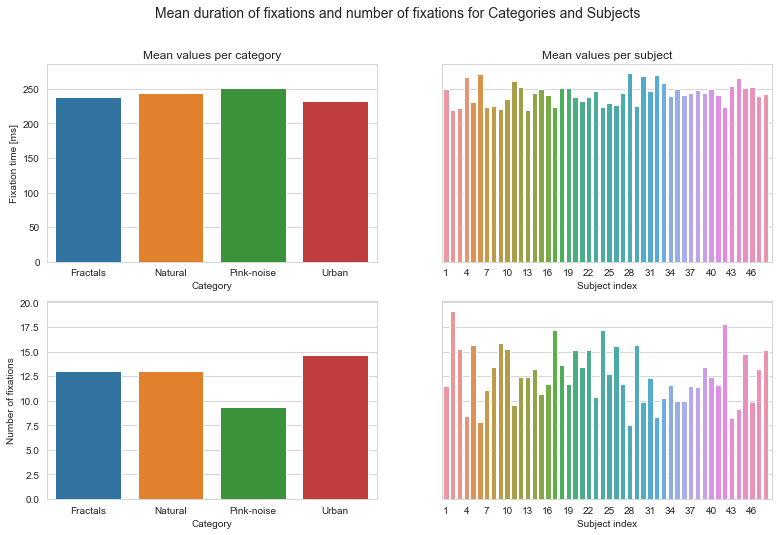

In [4]:
# calculate the required mean values
category_mean_dur = df_clean.groupby("category_name", as_index=False)["duration"].mean()
subject_mean_dur = df_clean.groupby("SUBJECTINDEX", as_index=False)["duration"].mean()

# get number of fixations per category, trial and subject
n_fix = df_clean.groupby(["category_name", "trial", "SUBJECTINDEX"], as_index=False)["fix"].count()
# get mean number of fixations per category and subject
category_mean_fix = n_fix.groupby("category_name", as_index=False)["fix"].mean()
subject_mean_fix = n_fix.groupby("SUBJECTINDEX", as_index=False)["fix"].mean()

# plot the required bar plots
figs, axes = plt.subplots(nrows=2, ncols=2, figsize=(13,8), sharey='row')
sns.barplot(x="category_name", y="duration", data = category_mean_dur, ax=axes[0,0])
sns.barplot(x="SUBJECTINDEX", y="duration", data = subject_mean_dur, ax=axes[0,1])
sns.barplot(x="category_name", y="fix", data = category_mean_fix, ax=axes[1,0])
sns.barplot(x="SUBJECTINDEX", y="fix", data = subject_mean_fix, ax=axes[1,1])

# take care of asthetics
subjects = np.arange(1, 49, 3)
figs.suptitle('Mean duration of fixations and number of fixations for Categories and Subjects', fontsize=14)
axes[0,0].set(title = "Mean values per category", ylabel = 'Fixation time [ms]', xlabel = 'Category')

axes[0,1].set(title = 'Mean values per subject', xlabel = 'Subject index', ylabel='')
axes[0,1].set_xticks(np.arange(0, 49, 3))
axes[0,1].set_xticklabels(subjects)

axes[1,0].set(ylabel = 'Number of fixations', xlabel = 'Category')

axes[1,1].set(xlabel = "Subject index", ylabel='')
axes[1,1].set_xticks(np.arange(0, 49, 3))
axes[1,1].set_xticklabels(subjects);

### d) normally distributed data [3 pts]
As ANOVA and lots of other statistical tests can be used only for normally distributed varaibles, it makes sense to find out whether the fixation duration and the number of fixations per trial is also normally distributed. This can be done with a Q-Q-Plot, which  is a graphical technique for determining if two data sets come from populations with a common distribution, in this case a normal distribution (for more information, klick [here](https://www.itl.nist.gov/div898/handbook/eda/section3/eda33o.htm)).
- make a Q-Q plot of the variable *fixation duration*. Is it approximately normally distributed?
- make a Q-Q plot of the variable *# fixation per trial*. Is it approximately normally distributed?

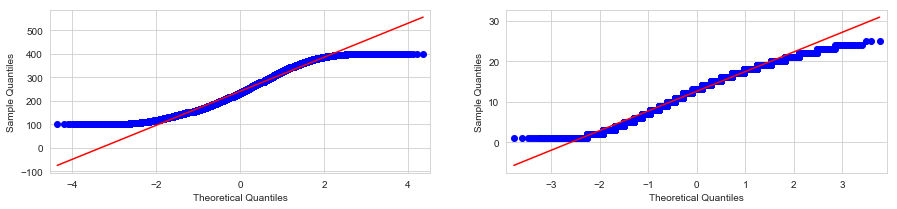

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,3))

prob = sm.ProbPlot(df_clean.duration, dist="norm")
a = prob.qqplot(line="r", ax=axes[0])
prob2 = sm.ProbPlot(df_clean.groupby(["trial", "SUBJECTINDEX"]).trial.count(),dist="norm")
b = prob2.qqplot(line="r", ax=axes[1])

**Visualize the distribution of all fixation durations to show that it is not even approximately normally distributed. This is in accordance with the results of the Q-Q-plot.**

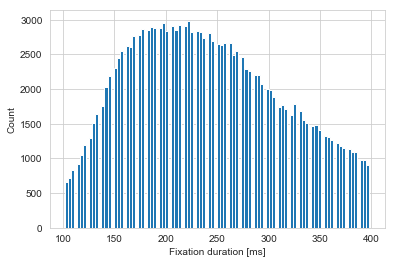

In [29]:
plt.hist(df_clean.duration, bins=100)
plt.ylabel('Count')
plt.xlabel('Fixation duration [ms]');

what do you think?

**Neither the fixation duration nor the number of fixations per trial are normally distributed. We would argue that they are not even apporximately normally distributed. For the fixation durations this can be clearly seen in the above histogram. Based on the Q-Q-plot the number of fixations is closer to a normal distribution than the fixation duration, but the tails also deviate from the normal distrubtion in this case.**

## Assignment 2: Hypothesis testing [3 pts]

### a) one way ANOVA [3 pts]
Now it's time to really prove our intuition. Test the following null hypotheses:  
$H01$: There is no difference in fixation duration across 4 different categories.  
$H02$: There is no difference in the number of fixations across 4 different categories.

What do you find?

In [8]:
res = AnovaRM(df_clean, 'duration', 'SUBJECTINDEX', within=['category'], aggregate_func='mean').fit()
res.summary()

,Num DF,Den DF,F Value,Pr > F
category,3.0000,141.0000,110.1916,0.0000


In [26]:
res = AnovaRM(df_clean, 'fix', 'SUBJECTINDEX', within=['category'], aggregate_func='count').fit()
res.summary()

,Num DF,Den DF,F Value,Pr > F
category,3.0000,141.0000,140.5947,0.0000


what do you say?

**In both ANOVAs we have to reject the null hypothesis. This would suggest, that there is a significant difference between fixation duration and number of fixations across the four different categories. We cannot say from the ANOVA alone which category/categories are different though. However this conclusion does not really hold, at least not for the duration. As you can see in the cell above the fixation durations are not really normally distributed but skewed instead. So we are not justified in performing an ANOVA for the fixation duration anyways since it is not even apporximately normally distribution. For number of fixations this is not clear, since the Q-Q-plot only looks at number of fixations across trials but the ANOVA is for number of fixations per category. As can be seen in task 1c, there is a huge difference in the number of fixations per category.**

## Assignment 3: Binning [4 pts]

### a) distribution of # fixation [2 pts]
Now we would like to know if there's a difference in terms of fixation numbers at different time segment.
- make a histogram with x axis being the start time of fixation
- the bin size should be 1 sec. In total there would be 6 bins.
- average over all subjects and images, just make a one simple plot
- figure out mean fixation duration for each bin and print it


Mean fixation duration per bin: 
 [232.6497, 242.79604, 243.08504, 243.18309, 243.08418, 237.64081]


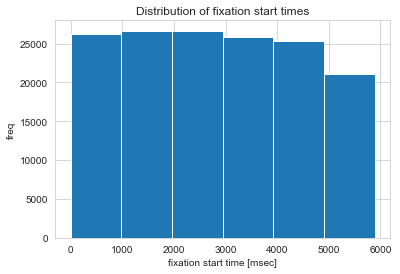

In [31]:
fig, ax = plt.subplots()
n, bins, _ = ax.hist(df_clean.start, bins=6)
ax.set(ylabel = 'freq', xlabel='fixation start time [msec]', title='Distribution of fixation start times');
mean = []
for (i,b) in enumerate(bins[:6]):
    mean_bin = df_clean[(df_clean["start"] >= b) & (df_clean["start"] < bins[i+1])].duration.mean()
    mean.append(mean_bin)
print("Mean fixation duration per bin: \n", mean)

**It is crucial here to not make bins of 1sec each. Since the highest fixation start time is 5892 ms, the bins would not be evenly distributed if they were of width 1sec each. Meaning the last bin would only contain values in the interval [5000, 5892] while all other bins contain values from a larger interval. If one uses the bin edges provided by the hist function instead they are all of the same width. This affects the calculation of mean values for the bins and also has a non-noticeable impact on the leftward bias plot.**

### b) leftward bias [2 pts]
If you took Action & Cognition I, you have probably heard about the leftward bias in human's fixation behavior. It is known that people tend to look more at the left visual field for the initial first second. Check whether this holds for our dataset as well.
- make a pointplot with x-axis as the x-coordinate of each fixation point and y-axis as the time bin to which the fixation point belongs to.
- mark the confidence interval around each point.
- make a vertical line at middle point of the x values. The x-coordinate of the fixation point in the data is based on the coordinate system using the display resolution. You can find out the information about display resolution by taking a look at the meta data.

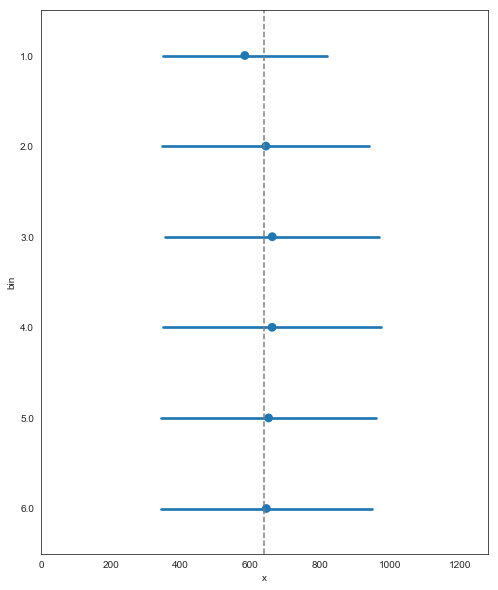

In [42]:
sns.set_style("white")
# add the bin as a column
df_clean['bin'] = df_clean['trial']
for (i, b) in enumerate(bins[:6]):
    df_clean['bin'] = np.where((df_clean["start"] >= b) & (df_clean["start"] <= bins[i+1]), i+1, df_clean['bin'])
# make this column a categorical column for plotting
df_clean['bin'] = df_clean['bin'].astype('category')

fig, axes = plt.subplots()
fig.set_size_inches(8, 10)

# use standard deviation from the mean as confidence interval
sns.pointplot(x ='x', y='bin', data=df_clean, join=False, ci="sd")

# setting the x limits according to image size
plt.xlim((0,1280))
# add vertical line at middle of x range
plt.axvline(x=640, color='gray', linestyle='--');

## Assignment 4: Heatmap [4 pts]
Now let's use heatmap to visualize which part of pictures is fixated for how long. It would be also good to know if there's a difference between categories.
- make a heatmap for data consisting of each categories and then averaged across all data.
- mark a central point in the plot.
- you can use ```numpy.histogram2d``` to compute a bi-dimensional histogram.
- then you can use ```pyplot.imshow``` to plot these histogram.
- don't forget to use the parameter ```extent``` to control for the bounding box to which the image should fit in.
- if you want to use other functions that's surely fine as well.

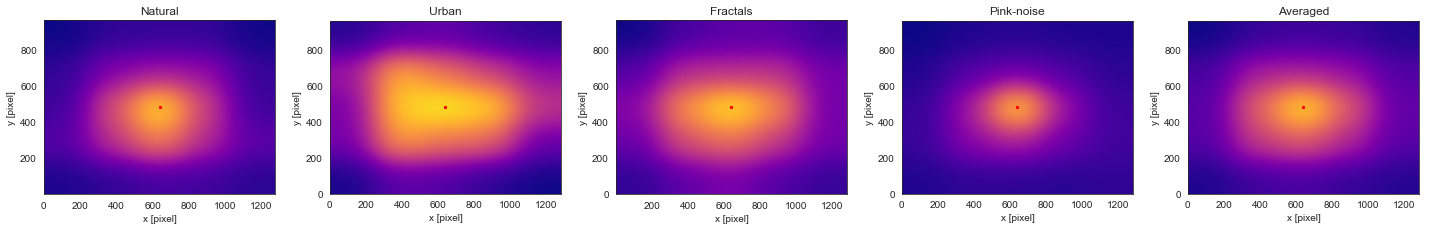

In [57]:
# store category names for plot titles and filtering
c_names = ["Natural", "Urban", "Fractals", "Pink-noise"]

# plot 5 heat maps
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20,12))
for (i,c) in enumerate(c_names):
    # filter for category name
    temp = df_clean[df_clean["category_name"]==c]
    # get the heat map data
    H, xedges, yedges = np.histogram2d(x=temp.x, y=temp.y, bins=5)
    axes[i].imshow(H.T, interpolation='gaussian', origin='low',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="plasma")
    # set labels and add center dot
    axes[i].set(title=c, xlabel="x [pixel]", ylabel="y [pixel]")
    axes[i].scatter(640, 480, s=5, c='red', marker='o')
# generate the heat map averaged over all categories
H, xedges, yedges = np.histogram2d(x=df_clean.x, y=df_clean.y, bins=5)
im = axes[4].imshow(H.T, interpolation='gaussian', origin='low',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="plasma")
axes[4].set(title="Averaged", xlabel="x [pixel]", ylabel="y [pixel]")
axes[4].scatter(640, 480, s=5, c='red', marker='o');
fig.tight_layout()

## Assignment 5: Scanpath [5 pts]
We want to know whether different scan behaviour is used when viewing images of different categories. Scanpath is a path followed by the eyes when viewing a stimulus. Scanpaths are useful for analyzing cognitive intent, interest, and salience. It has an advantage to a heatmap because the information about temporal structure of viewing behaviour can be plotted.
- make four plots, one for each category.
- randomely choose one trial for which you will plot a scanpath.
- mark fixation points based on the x-y coordinates.
- plot the *saccade path* from one fixation point to another one.
- make sure that the order of fixation can be read out from the plot. E.g. earlier fixations could have a light color whereas later fixations could have dark colors.
- also include information about the duration of each fixation. One way to do it is the use the size of the fixation marker.
- plot the background image superimposed with the scanpath. 

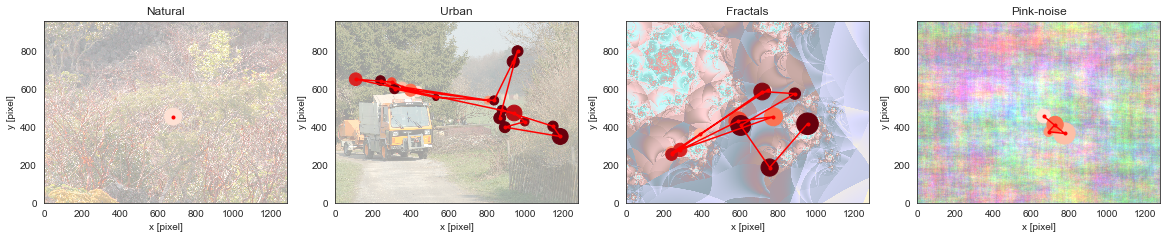

In [67]:
# import circles to draw on the image
from matplotlib.patches import Circle

# store category names to iterate over and label plots
c_names = ["Natural", "Urban", "Fractals", "Pink-noise"]

# plot the scanpath
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,12))
# use Reds colormap for fixation locations
cmap = plt.cm.get_cmap('Reds')
for (i,c) in enumerate(c_names):
    # randomly draw a trial and a subject
    r_trial = float(np.random.randint(1, 256))
    # filter the data table for the category and the trial
    df_trial = df_clean[(df_clean["category_name"] == c) & (df_clean["trial"] == r_trial)]
    # get all subjects that performed this trial in the given category
    subjects = df_trial.SUBJECTINDEX.unique()
    # chose a random subject to draw the scanpath for and filter for that subject
    r_subject = np.random.choice(subjects, 1)
    df_trial_sub = df_trial[df_trial["SUBJECTINDEX"] == r_subject[0]]
    # load the image to overlay the scanpath on
    cat = int(df_trial_sub.category.unique()[0])
    im = int(df_trial_sub.filenumber.unique()[0])
    axes[i].imshow(mpl.image.imread(DATAPATH+'Stimuli_{}/{}/{}.png'.format(cat, cat, im)), extent=(0,1280,0,960), alpha = 0.4)
    # store x and y position and duration of fixations as lists
    xpix = df_trial_sub['x'].tolist()
    ypix = df_trial_sub['y'].tolist()
    dur = df_trial_sub['duration'].tolist()
    # create fixation dots
    for m in range(len(xpix)):
        # later fixation points will be darker
        rgba = cmap(((m + 1) * 30))
        # draw fixation dots, longer fixations will have larger dots
        p1 = Circle((xpix[m],ypix[m]), radius=(dur[m]/7), color=(rgba))
        axes[i].add_patch(p1)
    # plot the saccade path
    axes[i].plot(xpix, ypix, '.r-')
    axes[i].set(title=c, xlabel="x [pixel]", ylabel="y [pixel]")

# Citation
Wilming N, Onat S, Ossandón J, Acik A, Kietzmann TC, Kaspar K, Gameiro RR, Vormberg A, König P (2017) An extensive dataset of eye movements during viewing of complex images. Scientific Data 4: 160126. https://doi.org/10.1038/sdata.2016.126  
Wilming N, Onat S, Ossandón J, Acik A, Kietzmann TC, Kaspar K, Gameiro RR, Vormberg A, König P (2017) Data from: An extensive dataset of eye movements during viewing of complex images. Dryad Digital Repository. https://doi.org/10.5061/dryad.9pf75